In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.models import load_model
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.metrics import roc_curve, auc
%matplotlib inline



In [2]:
print(tf.__version__)
print(keras.__version__)
print(np.__version__)

2.6.3
2.6.0
1.19.5


# Image Preparation


In [3]:
train_path='dataset/train'
valid_path='dataset/valid'
test_path='dataset/test'

In [4]:
train_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path,target_size=(224,224),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(valid_path,target_size=(224,224),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path,target_size=(224,224),batch_size=10,shuffle=False)

Found 1500 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


# Modify Model

In [5]:
mobile1=keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 7s 0us/step


In [6]:
mobile1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [7]:
x=mobile1.layers[-6].output
predictions=Dense(5,activation='softmax')(x)
model=Model(inputs=mobile1.input,outputs=predictions)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [9]:
for layer in model.layers[:-5]:
    layer.trainable=False

# Train the model

In [10]:
tensorboard=TensorBoard(log_dir="logs/{}".format(time()))
model.compile(Adam(lr=.001),loss='categorical_crossentropy',metrics=['accuracy'])

C:\Users\thisa\anaconda3\envs\research4\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
model.fit_generator(train_batches,steps_per_epoch=150,validation_data=valid_batches,validation_steps=10,epochs=10,verbose=2,callbacks=[tensorboard])

C:\Users\thisa\anaconda3\envs\research4\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
150/150 - 57s - loss: 0.3584 - accuracy: 0.8753 - val_loss: 2.7618 - val_accuracy: 0.5900
Epoch 2/10
150/150 - 69s - loss: 0.1072 - accuracy: 0.9660 - val_loss: 4.4949 - val_accuracy: 0.4200
Epoch 3/10
150/150 - 57s - loss: 0.0567 - accuracy: 0.9820 - val_loss: 1.0189 - val_accuracy: 0.8000
Epoch 4/10
150/150 - 78s - loss: 0.0223 - accuracy: 0.9940 - val_loss: 1.4058 - val_accuracy: 0.7600
Epoch 5/10
150/150 - 88s - loss: 0.0245 - accuracy: 0.9913 - val_loss: 0.1130 - val_accuracy: 0.9500
Epoch 6/10
150/150 - 85s - loss: 0.0247 - accuracy: 0.9933 - val_loss: 3.5739 - val_accuracy: 0.4500
Epoch 7/10
150/150 - 98s - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0329 - val_accuracy: 0.9900
Epoch 8/10
150/150 - 90s - loss: 0.0110 - accuracy: 0.9953 - val_loss: 1.7329 - val_accuracy: 0.6500
Epoch 9/10
150/150 - 114s - loss: 0.0217 - accuracy: 0.9927 - val_loss: 0.5689 - val_accuracy: 0.8400
Epoch 10/10
150/150 - 78s - loss: 0.0193 - accuracy: 0.9927 - val_loss: 2.6453 - val_accur

In [12]:
model.save(filepath="save_model/")

INFO:tensorflow:Assets written to: save_model/assets


# Predict

In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

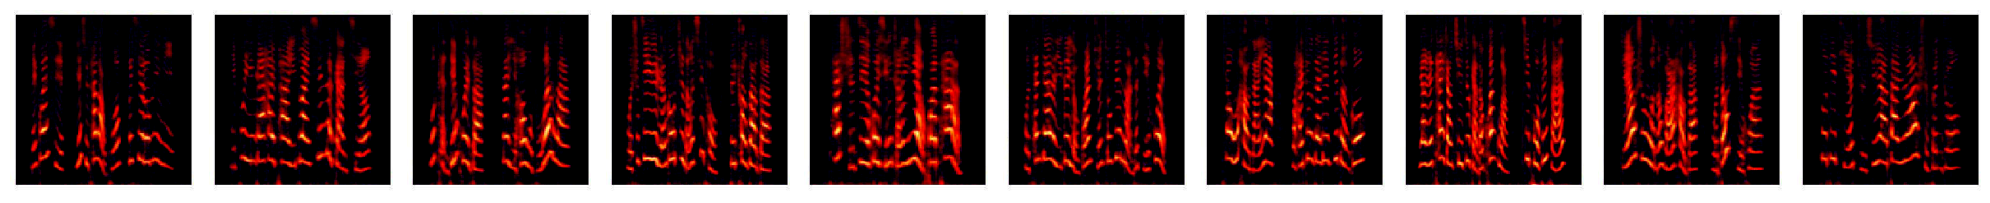

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [14]:
test_imgs,test_labels=next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [15]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [16]:
predictions=model.predict(x=test_batches,verbose=0)

In [17]:
np.round(predictions)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.

In [18]:
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
test_batches.class_indices

{'level1': 0, 'level2': 1, 'level3': 2, 'level4': 3, 'level5': 4}

Confusion matrix, without normalization
[[ 0  0  0  0 20]
 [ 0 10  0  1  9]
 [ 0  0 14  1  5]
 [ 0  0  0 20  0]
 [ 0  0  0  0 20]]


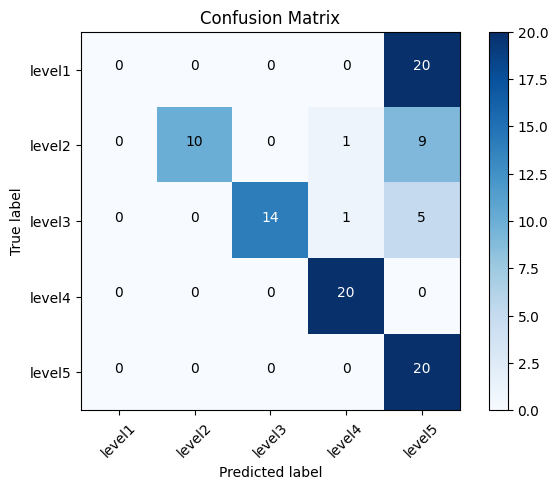

In [21]:
# cm_plot_labels=['0','1','2','3','4','5','6','7','8']
cm_plot_labels=['level1','level2','level3','level4', 'level5']
# cm_plot_labels=['0','1','2','3','4','5','6','7','8']
plt.figure()
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')

# Save trained keras model

In [22]:
model.save('stress_analyer_voice.h5')

# Do predictions from saved model

In [23]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
import datetime
import time
model=load_model('stress_analyer_voice.h5')

# Prediction

In [24]:
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

path  = ('dataset/test/level1')
filenames = os.listdir(path)
total_objectdetected_images=0
for file in filenames:
    print(file)
    img_path='dataset/test/level1/'+file
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    result1=model.predict(x)
    list1 = result1.tolist()
    finalresult=list1[0]
    max_value = max(finalresult)
    max_index = finalresult.index(max_value)
 
    
    print(max_value)
    if max_index==0:
        print("level1")
    elif max_index==1:
        print("level2")
    elif max_index==2:
        print("level3")
    elif max_index==3:
        print("level4")
    elif max_index==4:
        print("level5")
   
 

0001_000751.jpg
0.9995884299278259
level5
0001_000752.jpg
0.9997788071632385
level5
0001_000753.jpg
0.9955881834030151
level5
0001_000754.jpg
0.9999260902404785
level5
0001_000755.jpg
0.9999957084655762
level5
0001_000756.jpg
0.9999963045120239
level5
0001_000757.jpg
0.9084077477455139
level5
0001_000758.jpg
0.9999997615814209
level5
0001_000759.jpg
0.9993446469306946
level5
0001_000760.jpg
0.9813481569290161
level5
0001_000762.jpg
0.9999898672103882
level5
0001_000763.jpg
0.9993301630020142
level5
0001_000764.jpg
0.9981170892715454
level5
0001_000765.jpg
0.9910724759101868
level5
0001_000766.jpg
0.9999470710754395
level5
0001_000767.jpg
0.9999871253967285
level5
0001_000768.jpg
0.9999998807907104
level5
0001_000769.jpg
0.9968572854995728
level5
0001_000770.jpg
0.9997801184654236
level5
0001_000771.jpg
0.9999129772186279
level5
